In [26]:
import pandas as pd

# Load the CSV
df = pd.read_csv("aapl_stock_data.csv")

# Drop the fake header row (where "Open" column is literally the word "Open" or "AAPL")
df = df[df["Open"] != "Open"]
df = df[df["Open"] != "AAPL"]

# Convert columns to numeric safely
cols = ["Open", "High", "Low", "Close", "Volume"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values after conversion
df.dropna(subset=cols, inplace=True)

# Reset index and save to a new cleaned file
df.reset_index(drop=True, inplace=True)
df.to_csv("aapl_stock_data_cleaned.csv", index=False)

print("Cleaned and saved to aapl_stock_data_cleaned.csv")
print(df.head())



Cleaned and saved to aapl_stock_data_cleaned.csv
         Date        Open        High         Low       Close    Volume Ticker
0  2024-04-01  170.162333  170.221970  168.462591  169.009293  46240500   AAPL
1  2024-04-02  168.064996  168.323430  167.220093  167.826431  49329500   AAPL
2  2024-04-03  167.776723  169.655377  167.567993  168.631561  47691700   AAPL
3  2024-04-04  169.267710  170.887930  167.806549  167.806549  53704400   AAPL
4  2024-04-05  168.571931  169.367132  167.935774  168.561996  42055200   AAPL


In [37]:
import requests
from textblob import TextBlob
import pandas as pd
from datetime import datetime, timedelta

# Loading cleaned stock data
df = pd.read_csv("aapl_stock_data_cleaned.csv")
df["Date"] = pd.to_datetime(df["Date"])  # changed the date which was string to a datetime object so it can be used to calc the time intervals (for the Reddit API)

# defining the function which will fetch the sentiment avg.
def get_sentiment_for_date(date, query="AAPL", subreddit="stocks"):
    start_epoch = int(date.timestamp())
    end_epoch = int((date + timedelta(days=1)).timestamp())

    url = f"https://api.pushshift.io/reddit/search/submission/?q={query}&subreddit={subreddit}&after={start_epoch}&before={end_epoch}&size=100"

    try:
        response = requests.get(url, timeout=10)
        data = response.json().get("data", [])
    except Exception as e:
        print(f"⚠️ Error fetching data for {date.date()} in r/{subreddit}: {e}")
        return 0.0

    sentiments = []
    for post in data:
        title = post.get("title", "")
        if title:
            sentiment = TextBlob(title).sentiment.polarity
            sentiments.append(sentiment)

    if sentiments:
        return sum(sentiments) / len(sentiments)
    else:
        return 0.0


       
# Test the function on the first date in your dataset
sample_date = df["Date"].iloc[0]
score = get_sentiment_for_date(sample_date)
print(f"Sentiment score for {sample_date.date()} is {score}")


Sentiment score for 2024-04-01 is 0.0


In [38]:
#Picks a date from the dataset
#Runs get_sentiment_for_date(...)
#Stores the date and score into a list

#this list will store each day's sentiment
sentiment_data = []

#looping here through every date in stock data
for date in df["Date"]:

    print(f"fetching sentiment for{date.date()}...")

    score = 0 # this will hold the total sentiment across subreddits
 # Run sentiment collection on 3 subreddits
    for sub in ["stocks", "investing", "wallstreetbets"]:
        score += get_sentiment_for_date(date, subreddit=sub)

    avg_score = score / 3  # average sentiment across 3 subs

    # Save date and sentiment score to our list
    sentiment_data.append({"Date": date, "Sentiment_Reddit": avg_score})

# Full Merging Block (with your understanding built in)
# Convert the list of sentiment results to a DataFrame
sentiment_df = pd.DataFrame(sentiment_data)

# Merge this with the stock data on the Date column
final_df = pd.merge(df, sentiment_df, on="Date", how="left")

# Save the merged result to a new CSV file
final_df.to_csv("aapl_with_sentiment.csv", index=False)

# Confirmation
print("Final dataset with sentiment saved to aapl_with_sentiment.csv")

import pandas as pd

# Load our combined dataset
df = pd.read_csv("aapl_with_sentiment.csv")

# Shift the Close column upward to get "next day's close"
df["Next_Close"] = df["Close"].shift(-1)

# Drop the last row since it has no 'Next_Close' value
df.dropna(inplace=True)

# Show the structure
print(df[["Date", "Close", "Next_Close", "Sentiment_Reddit"]].head())



fetching sentiment for2024-04-01...
fetching sentiment for2024-04-02...
fetching sentiment for2024-04-03...
fetching sentiment for2024-04-04...
fetching sentiment for2024-04-05...
fetching sentiment for2024-04-08...
fetching sentiment for2024-04-09...
fetching sentiment for2024-04-10...
fetching sentiment for2024-04-11...
⚠️ Error fetching data for 2024-04-11 in r/stocks: HTTPSConnectionPool(host='api.pushshift.io', port=443): Read timed out. (read timeout=10)
fetching sentiment for2024-04-12...
fetching sentiment for2024-04-15...
⚠️ Error fetching data for 2024-04-15 in r/stocks: HTTPConnectionPool(host='api.pushshift.io', port=80): Read timed out. (read timeout=10)
⚠️ Error fetching data for 2024-04-15 in r/wallstreetbets: HTTPSConnectionPool(host='api.pushshift.io', port=443): Read timed out. (read timeout=10)
fetching sentiment for2024-04-16...
⚠️ Error fetching data for 2024-04-16 in r/investing: HTTPSConnectionPool(host='api.pushshift.io', port=443): Read timed out. (read timeout

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare the data again (if kernel was reset)
df = pd.read_csv("aapl_with_sentiment.csv")
df["Next_Close"] = df["Close"].shift(-1)
df.dropna(inplace=True)

# Define features and target
features = ["Open", "High", "Low", "Volume", "Sentiment_Reddit"]
X = df[features].values
y = df["Next_Close"].values.reshape(-1, 1)

# Add intercept (bias column)
ones = np.ones((X.shape[0], 1))
X_b = np.hstack([ones, X])

# Train with normal equation (pseudo-inverse)
w = np.linalg.pinv(X_b).dot(y)
y_pred = X_b.dot(w)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\n📊 Evaluation Metrics:")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² Score: {r2:.4f}")



📊 Evaluation Metrics:
RMSE: 2.1882
MAE : 1.5264
R² Score: 0.3968


C:\Users\RAO\AppData\Local\Temp\ipykernel_18956\1010957385.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\RAO\anaconda3.1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


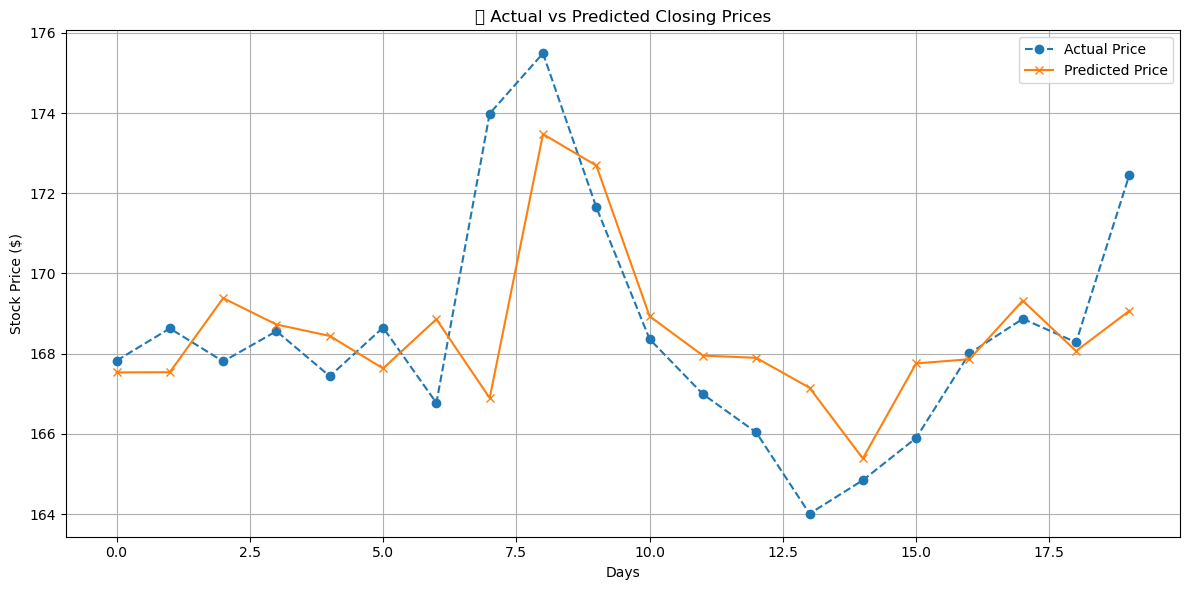

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y, label="Actual Price", linestyle="--", marker='o')
plt.plot(y_pred, label="Predicted Price", linestyle="-", marker='x')
plt.title("📈 Actual vs Predicted Closing Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
print("\n🔍 Feature Weights (including bias):")
for name, value in zip(["Bias"] + features, w.flatten()):
    print(f"{name:<20}: {value:.6f}")



🔍 Feature Weights (including bias):
Bias                : 110.676399
Open                : -1.258861
High                : 0.919832
Low                 : 0.683151
Volume              : -0.000000
Sentiment_Reddit    : 0.000000


In [5]:
from sklearn.linear_model import LinearRegression

# Train using sklearn
model = LinearRegression()
model.fit(X, y)
y_pred_sklearn = model.predict(X)

# Compare first few predictions
print("\n📊 Sklearn Model Comparison:")
for i in range(5):
    print(f"Day {i+1}: Sklearn = {y_pred_sklearn[i][0]:.2f} | Manual = {y_pred[i][0]:.2f}")



📊 Sklearn Model Comparison:
Day 1: Sklearn = 167.53 | Manual = 167.53
Day 2: Sklearn = 167.54 | Manual = 167.54
Day 3: Sklearn = 169.39 | Manual = 169.39
Day 4: Sklearn = 168.73 | Manual = 168.73
Day 5: Sklearn = 168.44 | Manual = 168.44
